In [154]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cvxpy as cp
import itertools

In [8]:
'''
Assume two-way factorial design 
Heterogenuous Treatment Effect

Build Simple Python Function Based on This
1) Dataframe
2) Treatment Cols [Assume in {-1, 1}]
3) Covariate Cols [Assume Numerical]
5) G Column [Assume in {-1, 1}]

Build More Functionality
1) Specify Basis Functions
'''

'\nAssume two-way factorial design \nHeterogenuous Treatment Effect\n\n1) Assume K = 2\n2) Assume Basis Functions are Linear\n3) Assume Only 1 Interaction Effects\n\nBuild Simple Python Function Based on This\n1) Dataframe\n2) Treatment Cols [Assume in {-1, 1}]\n3) Covariate Cols [Assume Numerical]\n5) G Column [Assume in {-1, 1}]\n\nBuild More Functionality\n1) Specify Basis Functions\n2) Specify Number of Interaction Effects\n'

In [370]:
num_points = 10000
df = pd.DataFrame()
num_treatments = 5

for i in range(num_treatments):
    treat_name = 'z'+str(i)
    df[treat_name] = (2 * (np.random.randint(0, 2, num_points) - 0.5)).astype(int)

num_covs = 5
for i in range(num_covs):
    cov_name = 'x'+str(i)
    df[cov_name] = np.random.randint(0, 2, num_points)
    
df['y'] = np.random.randint(0, 2, num_points)

In [407]:
def find_weighting(df, treat_cols, cov_cols, effects, weighting = 'entropy', intr_effects = 1):
    assert weighting == 'entropy' or weighting == 'variance'
    assert len(np.unique(df[treat_cols].values, axis = 0)) == 2**len(treat_cols)
    
    x = cp.Variable(len(df))
    obj = None
    if weighting == 'entropy':
        obj = cp.Minimize(-cp.sum(cp.entr(x)))
    if weighting == 'variance':
        obj = cp.Minimize(cp.sum_squares(x))
    
    constraints = [x >= 0]
    
    df = df.copy()
    
    df['g'] = df[effects].prod(axis = 1)
    df['A_plus'] = np.maximum(df['g'], 0)
    df['A_minus'] = np.maximum(-df['g'], 0)
    
    treat_combos = [[ele] for ele in treat_cols]
    for i in range(2, intr_effects + 1):
        vals = list(itertools.combinations(treat_cols, i))
        list_vals = [list(ele) for ele in vals]
        treat_combos.extend(list_vals)
    
    sums = {}
    
    for cov_col in cov_cols:
        sums[cov_col] = df[cov_col].sum()
    
    for s in range(len(cov_cols)):
        for k in range(len(treat_combos)):
            cov_col = cov_cols[s]
            specific_treat_cols = treat_combos[k]
            
            #Get Treatment Vals
            z_val = df[specific_treat_cols].prod(axis = 1)
            
            #Left Side of Constraint
            plus_const = df['A_plus'] * df[cov_col] * z_val
            minus_const = df['A_minus'] * df[cov_col] * z_val
            
            #All Unique Z Combos
            z_combos = pd.DataFrame(np.unique(df[treat_cols].values, axis = 0), columns = treat_cols)
            
            #Right Side of Constraint
            plus_res, minus_res = 0, 0
            for j in range(len(z_combos)):
                g_value = z_combos.loc[j][effects].prod()
                mult = z_combos.loc[j][specific_treat_cols].prod()
                if g_value > 0:
                    plus_res += sums[cov_col] * mult
                if g_value < 0:
                    minus_res += sums[cov_col] * mult
            
            plus_res /= (2**(len(treat_cols) - 1))
            minus_res /= (2**(len(treat_cols) - 1))
            constraints.append(cp.multiply(x, plus_const).sum() == plus_res)
            constraints.append(cp.multiply(x, minus_const).sum() == minus_res)

    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS)
    return prob, x
            

In [413]:
prob, x = find_weighting(df, ['z0', 'z1', 'z2', 'z3'], 
                         ['x0', 'x1', 'x2', 'x3', 'x4'], 
                         ['z1', 'z2'], 'entropy', 2)

In [414]:
df['weights'] = x.value

In [415]:
df['g'] = df[['z1', 'z2']].prod(axis = 1)

(df['g'] * df['weights']).sum()/len(df)

-0.0006719202844200126

(array([2400., 2938., 2696.,  346., 1014.,  283.,   31.,  166.,  103.,
          23.]),
 array([0.3678794 , 0.93682987, 1.50578035, 2.07473082, 2.6436813 ,
        3.21263177, 3.78158225, 4.35053273, 4.9194832 , 5.48843368,
        6.05738415]),
 <BarContainer object of 10 artists>)

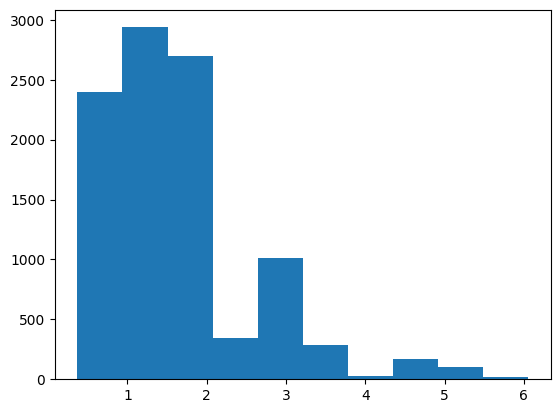

In [416]:
plt.hist(df['weights'])